# Stochastic Response
Richard M. Murray, 6 Feb 2022

This notebook illustrates the implementation of random processes and stochastic response.  We focus on a system of the form

$$
  \dot X = A X + F V \qquad X \in {\mathbb R}^n
$$

where $V$ is a white noise process and the system is a first order linear system.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import control as ct
from math import sqrt, exp

# Fix random number seed to avoid spurious figure regeneration
np.random.seed(1)

We begin by defining a simple first order system

$$
\frac{dX}{dt} = - a X + V, \qquad Y = c X
$$

and a (scalar) white noise signal $V$ with intensity $Q$.

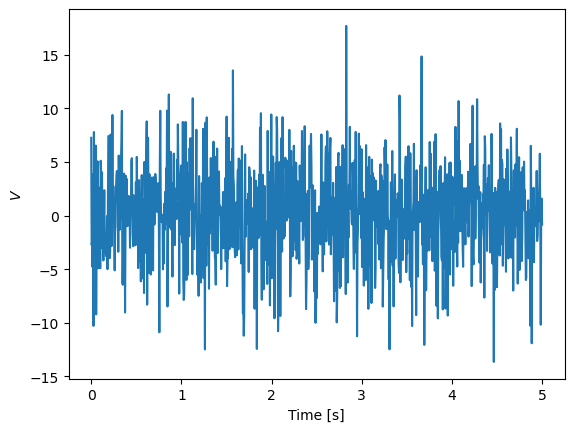

In [2]:
# First order system
a = 1
c = 1
sys = ct.ss([[-a]], [[1]], [[c]], 0)

# Create the time vector that we want to use
Tf = 5
T = np.linspace(0, Tf, 1000)
dt = T[1] - T[0]

# Create the basis for a white noise signal
Q = np.array([[0.1]])
V = ct.white_noise(T, Q)

plt.plot(T, V[0])
plt.xlabel('Time [s]')
plt.ylabel('$V$');

Note that the magnitude of the signal seems to be much larger than $Q$.  This is because we have a Gaussian process $\implies$ the signal consists of a sequence of "impulse-like" functions that have magnitude that increases with the time step $dt$ as $1/\sqrt{dt}$ (this gives covariance $\mathbb{E}(V(t_1) V^T(t_2)) = Q \delta(t_2 - t_1)$.

In [3]:
# Calculate the sample properties and make sure they match
print("mean(V) [0.0] = ", np.mean(V))
print("cov(V) * dt [%0.3g] = " % Q.item(), np.round(np.cov(V), decimals=3) * dt)

mean(V) [0.0] =  0.17348786109316244
cov(V) * dt [0.1] =  0.09633133133133133


The response of the system to white noise can be computed using the `input_output_response` function:

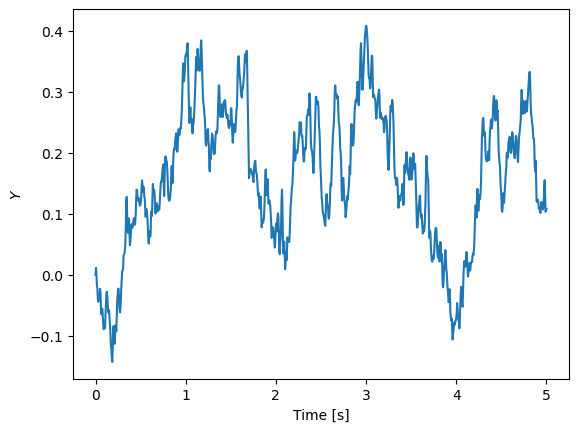

In [4]:
# Response of the first order system
T, Y = ct.input_output_response(sys, T, V)
plt.plot(T, Y)
plt.xlabel('Time [s]')
plt.ylabel('$Y$');

This is a first order system, and so we can compute the analytical correlation function and compare this to the sampled data:

In [5]:
# Compare static properties to what we expect analytically
def r(tau):
    return c**2 * Q / (2 * a) * exp(-a * abs(tau))
    
print("* mean(Y) [%0.3g] = %0.3g" % (0, np.mean(Y)))
print("* cov(Y) [%0.3g] = %0.3g" % (r(0).item(), np.cov(Y)))

* mean(Y) [0] = 0.161
* cov(Y) [0.05] = 0.013


Finally, we look at the correlation function for the input and the output:

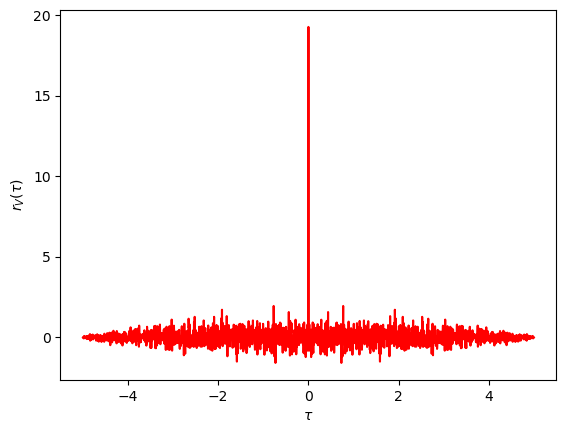

In [6]:
# Correlation function for the input
tau, r_V = ct.correlation(T, V)

plt.plot(tau, r_V, 'r-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$r_V(\tau)$');

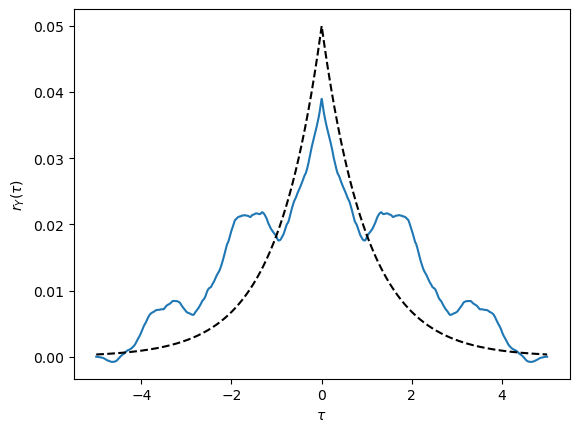

In [7]:
# Correlation function for the output
tau, r_Y = ct.correlation(T, Y)
plt.plot(tau, r_Y)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$r_Y(\tau)$')

# Compare to the analytical answer
plt.plot(tau, [r(t)[0, 0] for t in tau], 'k--');

The analytical curve may or may not line up that well with the correlation function based on the sample.  Try running the code again with a different random seed to see how things change based on the specific random sequence chosen at the start.

Note: the _right_ way to compute the correlation function would be to run a lot of different samples of white noise filtered through the system dynamics and compute $R(t_1, t_2)$ across those samples.  The `correlation` function computes the covariance between $Y(t + \tau)$ and $Y(t)$ by varying $t$ over the time range.